In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import tqdm
import shap
df_list=[]
for filenumber in tqdm.tqdm(range(1,10)):
# Open the .root file
    filePath=f'../36_files/JetNtuple_RunIISummer16_13TeV_MC_{filenumber}.root'
    file = uproot.open(filePath)
# Access the tree structure
    tree = file['AK4jets/jetTree']
# Define the columns you want to read
    columns = ['isPhysG', 'isPhysUDS','QG_mult','QG_ptD','QG_axis2','jetPt','jetEta','jetQGl','jetMass','jetGirth','jetArea','jetChargedHadronMult','jetNeutralHadronMult','jetChargedMult','jetNeutralMult']
    df=tree.arrays(columns, library='pd')
    df_list.append(df)
df=pd.concat(df_list,ignore_index='true')
# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()
#selecting only a range of pt 
df_pt_ranged=df[(df.jetPt>30) & (df.jetPt<600)]
df=df_pt_ranged

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

train_y = train.isPhysUDS
test_y = test.isPhysUDS
# training and test variables for each training variable
#input_features = ['QG_mult','QG_ptD','QG_axis2','jetPt','jetGirth','jetChargedHadronMult']
#Omitting jetPt
input_features = ['QG_mult','QG_ptD','QG_axis2','jetGirth','jetChargedHadronMult']

for input in input_features:
    train_x = train[[input]]
    test_x = test[[input]]
 # Normalize the features
    train_x_mean = train_x.mean()
    train_x_std = train_x.std()
    exec(f'train_x_{input}= (train_x - train_x_mean) / train_x_std')
    exec(f'test_x_{input} = (test_x - train_x_mean) / train_x_std')

train_x=train[input_features]
test_x=test[input_features]


100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


## SIMPLE DROPPED VARIABLE MODEL

In [9]:
from tensorflow.keras.models import load_model

model=load_model('../Main files/models/model.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               600       
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 15801 (61.72 KB)
Trainable params: 15801 (

In [10]:

explainer = shap.Explainer(model, train_x[0:100].to_numpy())
shap_values = explainer(test_x)

ExactExplainer explainer: 107280it [19:34, 90.79it/s]                             


In [9]:
np.shape(shap_values)

(10, 6)

In [30]:
type(shap_values)

shap._explanation.Explanation

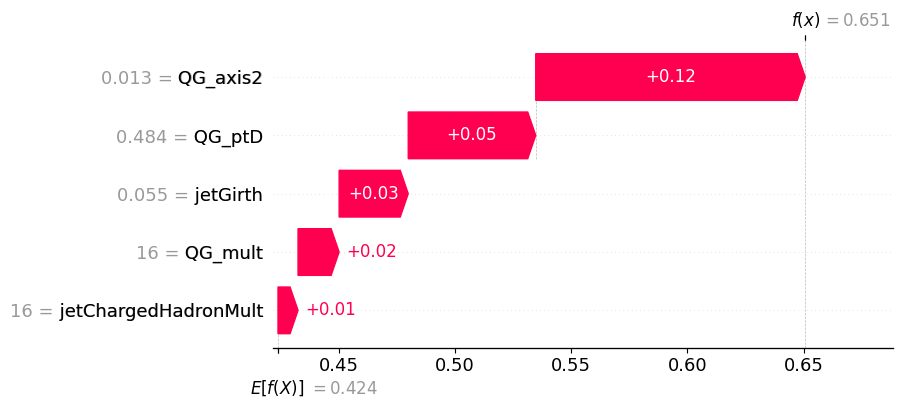

In [11]:
import shap
shap.initjs()
shap.plots.waterfall(shap_values[1050])

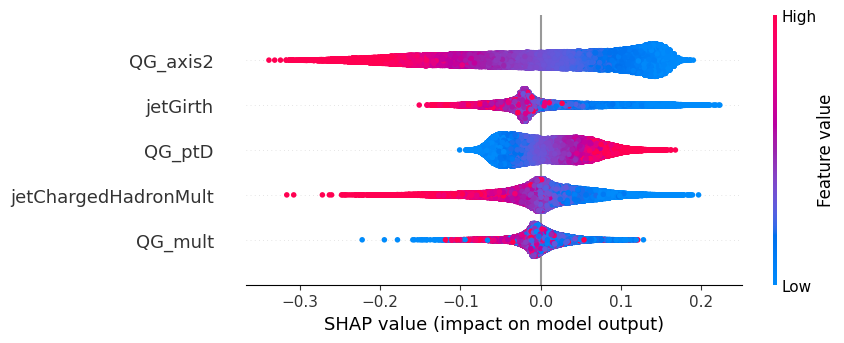

In [12]:
shap.initjs()
shap.plots.beeswarm(shap_values)

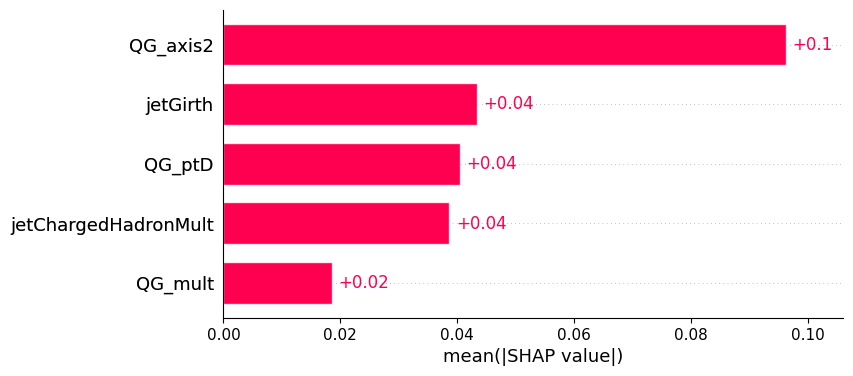

In [13]:
shap.initjs()
shap.plots.bar(shap_values)

## TUNED DROPPED VARIABLE MODEL

In [17]:
from tensorflow.keras.models import load_model

model=load_model('../Main files/models/new_model_tuned_drp_var.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 224)               7392      
                                                                 
 dense_4 (Dense)             (None, 128)               28800     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
 lastlayer (Dense)           (None, 1)                 1

In [20]:
explainer = shap.Explainer(model, train_x[0:100].to_numpy())
shap_values = explainer(test_x)

ExactExplainer explainer: 107280it [29:31, 60.20it/s]                            


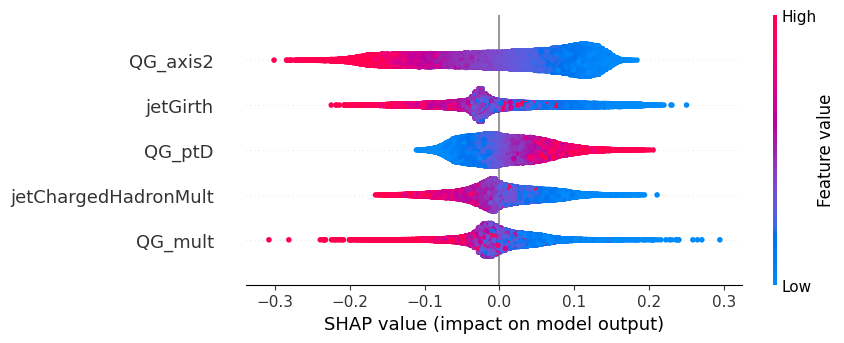

In [21]:
shap.initjs()
shap.plots.beeswarm(shap_values)

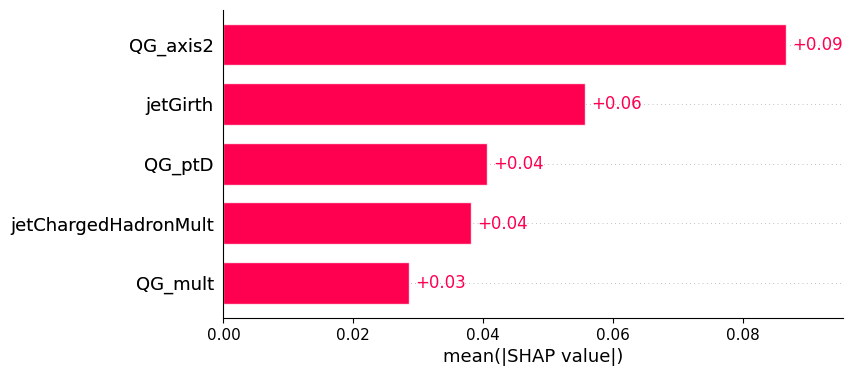

In [22]:
shap.initjs()
shap.plots.bar(shap_values)